# Preamble

In [482]:
import random
import json
import pandas as pd
import numpy as np
import typing
from pathlib import Path
from collections import Counter
import matplotlib
from matplotlib import pyplot as plt
from functools import reduce
import kendall_w.kendall_w as kw
import scipy.stats

## Functions to process individual subjects and find subjects within directory

In [3]:
from behavioral import process_subject, find_subject, compile_data

## Playground

In [4]:
tmp = find_subject("5f1f4497da321e111475a32e")

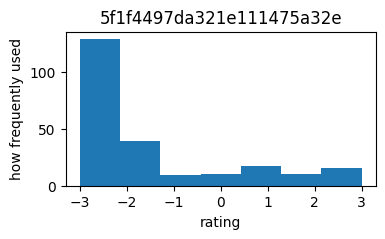

In [5]:
f, a = plt.subplots(figsize=(4,2))
a.hist(tmp.response, bins=7)
a.set(title=tmp.subject_id.iloc[0], xlabel='rating', ylabel='how frequently used')
plt.show()

## Load in all the data from this batch

In [4]:
df, subject_to_ix, ix_to_subject, item_to_ix, ix_to_item = compile_data()

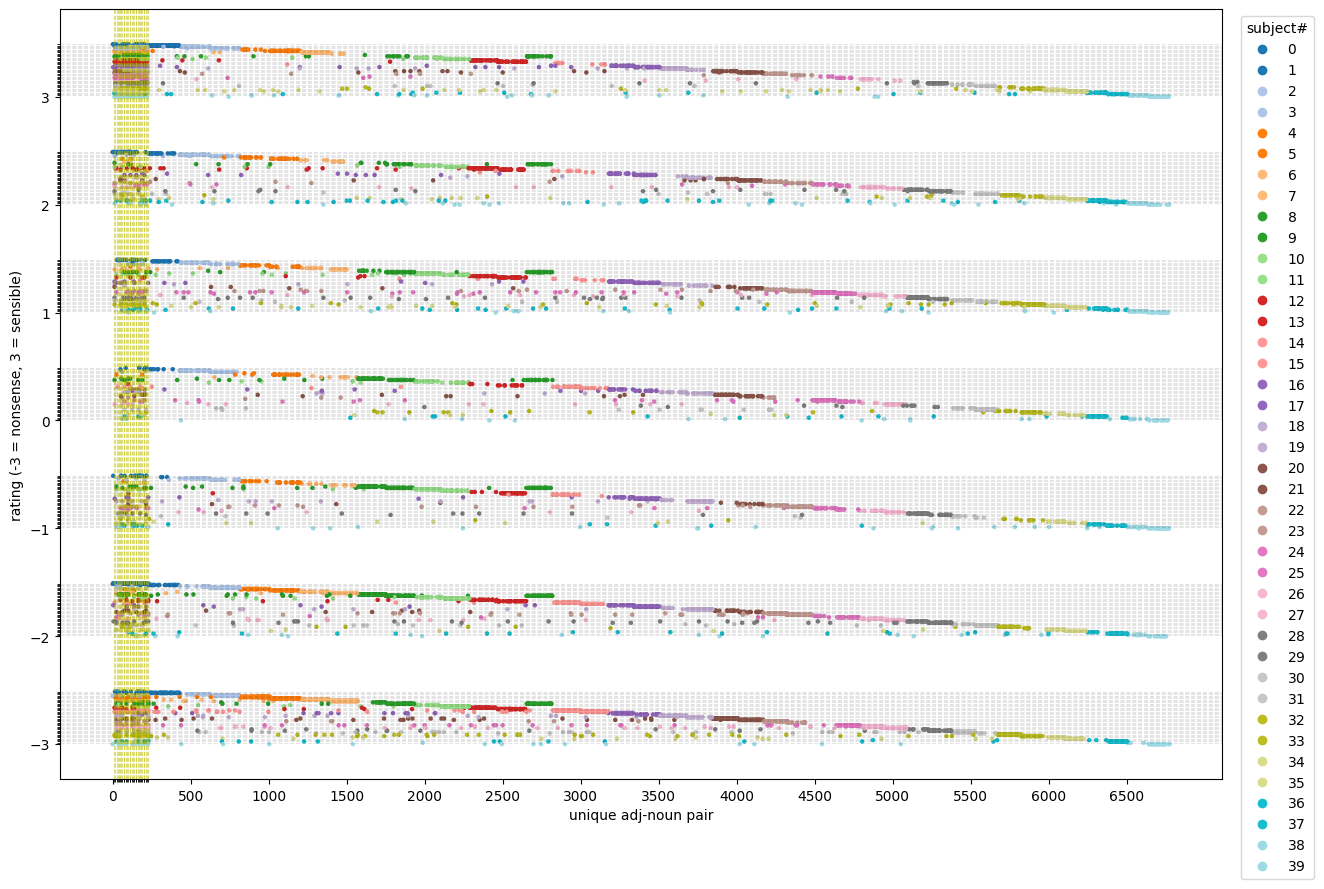

In [32]:
from matplotlib.colors import ListedColormap

view = df.sort_values(by="response")
# view = view[view['trial_type'] != 'crit']

f, a = plt.subplots(figsize=(15, 10))

col_ix = np.where(view["trial_type"] == "actual", 1, 0)
sub_ix = np.array([subject_to_ix[sub] for sub in view.subject_id])
cmap = ListedColormap(("r", "b"))

subject_wise_increment = 1 / len(subject_to_ix) / 2
scatter = a.scatter(
    view["item_index"],
    view["response"] + (len(subject_to_ix) - sub_ix - 1) * subject_wise_increment,
    c=sub_ix,
    s=5,
    alpha=1,
    cmap="tab20",
    # cmap="copper",
)

a.set_yticks(sorted(set(view["response"])))
min_rating = -3
max_rating = +3

a.set_xticks(
    np.arange(0, max(view.item_index), 500),
    minor=False,
    rotation=90,
)
a.set_xticks(
    sorted(
        {
            row["item_index"]
            for i, row in view[["item_index", "trial_type"]].iterrows()
            if row["trial_type"] in {"gold", "anti"}
        }
    ),
    minor=True,
)
a.set_yticks(
    reduce(
        list.__add__,
        [
            list(np.arange(i, i + 0.5, subject_wise_increment))
            for i in range(min_rating, max_rating + 1)
        ],
    ),
    minor=True,
)

a.set(xlabel="unique adj-noun pair", ylabel="rating (-3 = nonsense, 3 = sensible)")

plt.legend(
    *scatter.legend_elements(num=None),
    # labels=["gold", "actual"],
    # labels=[ix for ix in range(len(subject_to_ix))],
    # labels=subject_to_ix.values(),
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
    title="subject#",
)
plt.grid(alpha=0.1, which="minor", axis="y", visible=True, color="k", linestyle="--")
# plt.grid(alpha=0.1, which="minor", axis="x", visible=True, color="y")
plt.grid(
    alpha=0.5,
    which="minor",
    axis="x",
    visible=True,
    color="y",
    linestyle="--",
)

plt.show()


[Text(0.5, 0, 'rating'), Text(0, 0.5, 'frequency')]

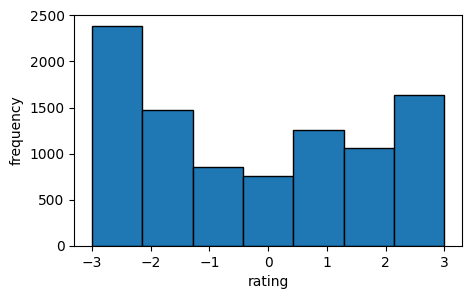

In [33]:
f,a = plt.subplots(figsize=(5,3))
a.hist(df['response'], bins=7, edgecolor='black')
a.set(xlabel='rating', ylabel='frequency')

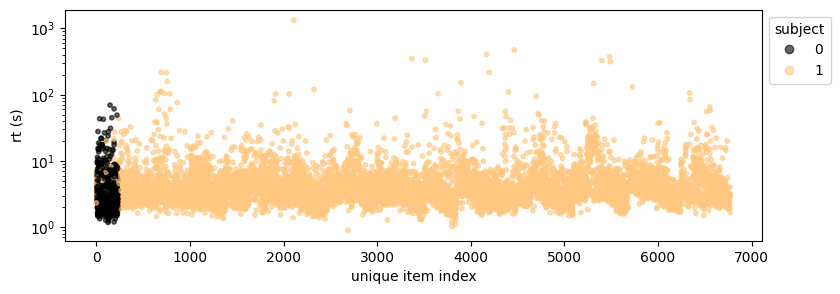

In [35]:
from matplotlib.colors import ListedColormap
inv = lambda dikt: {v:k for k,v in dikt.items()} 

f, a = plt.subplots(figsize=(9,3))

col_ix = np.where(df['trial_type'] == 'crit', 1, 0)
sub_ix = np.array([subject_to_ix[sub] for sub in df['subject_id']])

cmap = ListedColormap(('r', 'b'))
scatter = a.scatter(df['item_index'], df['rt']/10**3, c=col_ix, s=10, alpha=.6, cmap='copper')

a.set(yscale='log', ylabel='rt (s)', xlabel='unique item index')

plt.legend(
    *scatter.legend_elements(),
    # labels=[ix for ix in range(len(subject_to_ix))],
    bbox_to_anchor=(1., 1.),
    loc="upper left",
    title='subject',
)

plt.show()

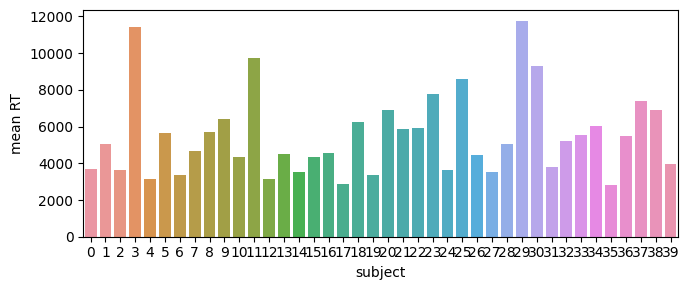

In [39]:
import seaborn as sns
f,a = plt.subplots(figsize=(7,3))
view = df.groupby('subject_id').mean().reset_index()
view['subject_ix'] = view['subject_id'].apply(lambda sub_id: subject_to_ix[sub_id])
bar = sns.barplot(data=view, x='subject_ix', y='rt')
# f.set_xticks(range(11))
# plt.xticks(rotation=70)
a.set(xlabel='subject', ylabel='mean RT')
plt.tight_layout()

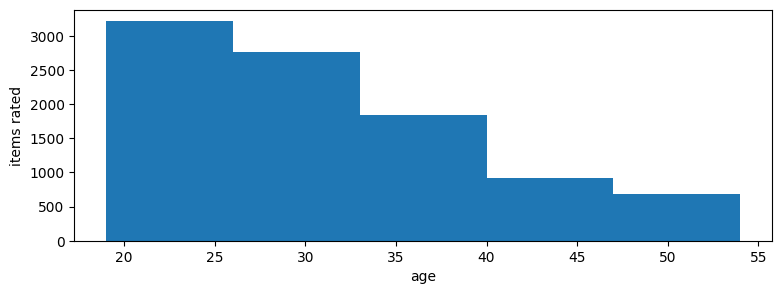

In [42]:
from matplotlib.colors import ListedColormap
inv = lambda dikt: {v:k for k,v in dikt.items()} 

f, a = plt.subplots(figsize=(9,3))

col_ix = np.where(df['trial_type'] == 'actual', 1, 0)
sub_ix = np.array([subject_to_ix[sub] for sub in df.subject_id])

cmap = ListedColormap(('r', 'b'))
hist = a.hist(df['age'], bins=5)

# a.set_xticks(np.arange(0, 30_000, 2_000))
# a.set(xscale='log')
a.set(xlabel='age', ylabel='items rated')

plt.show()

## Now let's compute metrics about inter-rater agreement

### Kendall's W

first, we'll need to artificially rank-order the responses per rater based on their rating.

```python
# Example
annotations = [
#    annotators
#    1  2  3  4
    [1, 1, 1, 2], # item 1 
    [2, 2, 2, 3], # item 2 
    [3, 3, 3, 1], # item 3
]
```

In [78]:
df[df.subject_id == '5de42a01a7cb2401ccc682c3'].sort_values(by='item_index')

,subject_id,study_id,country,language,gender,age,rt,time_elapsed,trial_index,item,response,trial_type,item_index
2082,5de42a01a7cb2401ccc682c3,637d1591e10c9bfd91689241,Other,Other,Male,32,11335,196321,12,pleasant midnight,0,anti,12
3232,5de42a01a7cb2401ccc682c3,637d1591e10c9bfd91689241,Other,Other,Male,32,4503,155184,12,pleasant midnight,3,anti,12
2088,5de42a01a7cb2401ccc682c3,637d1591e10c9bfd91689241,Other,Other,Male,32,2511,240947,18,young person,3,gold,18
3238,5de42a01a7cb2401ccc682c3,637d1591e10c9bfd91689241,Other,Other,Male,32,27745,211946,18,young person,3,gold,18
2095,5de42a01a7cb2401ccc682c3,637d1591e10c9bfd91689241,Other,Other,Male,32,2255,279557,25,comprehensive chapel,-3,anti,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3442,5de42a01a7cb2401ccc682c3,637d1591e10c9bfd91689241,Other,Other,Male,32,3623,1769914,222,Japanese dismissal,-2,crit,2815
3445,5de42a01a7cb2401ccc682c3,637d1591e10c9bfd91689241,Other,Other,Male,32,22361,1801500,225,fair occurrence,-2,crit,2816
3446,5de42a01a7cb2401ccc682c3,637d1591e10c9bfd91689241,Other,Other,Male,32,10464,1811964,226,elderly reception,1,crit,2817
3447,5de42a01a7cb2401ccc682c3,637d1591e10c9bfd91689241,Other,Other,Male,32,6903,1818869,227,democratic valve,-2,crit,2818


In [459]:
view = df[df.trial_type.isin(['anti'])]
ranks = []
for subj_id in view.subject_id.unique():
    subj_view = view[view.subject_id == subj_id]
    subj_view = subj_view.groupby('item').mean() # WARN!!!! TODO this is consolidating multiple ratings for the 
                                                 # same item by the same subject (one subject did this for some 
                                                 # reason, TBD whether to exclude)
    subj_view = subj_view.sort_values(by='response', ascending=False)
    corrected_ranks = subj_view.reset_index().reset_index().groupby(['response']).min()['index'].to_dict()
    corrected_ranks_ = {k: i+1 for i, (k, r) in enumerate(sorted(corrected_ranks.items(), key=lambda tup: tup[-1]))}
    rank = subj_view['response'].apply(lambda val: corrected_ranks_[val])
    subj_view['rank'] = rank.astype(int)
    subj_view = subj_view.sort_values(by='item_index')
    ranks.append(np.array(subj_view['rank']))
    # print(subj_id, len(subj_view))
ranks = np.vstack(ranks).T

In [460]:
subj_view

,age,rt,time_elapsed,trial_index,response,item_index,rank
item,,,,,,,
pleasant midnight,22.0,1631.0,152284.0,12.0,3.0,12.0,1
comprehensive chapel,22.0,10723.0,213565.0,25.0,3.0,25.0,1
vertical calorie,22.0,2500.0,267032.0,38.0,-3.0,38.0,5
magnetic philosopher,22.0,3222.0,308454.0,50.0,-3.0,50.0,5
Conservative arc,22.0,4060.0,365290.0,63.0,-3.0,63.0,5
southern apprentice,22.0,2433.0,405188.0,76.0,3.0,76.0,1
welcome misuse,22.0,3327.0,443806.0,88.0,-3.0,88.0,5
equal episode,22.0,4403.0,500261.0,101.0,1.0,101.0,3
lovely advertiser,22.0,9469.0,549490.0,114.0,3.0,114.0,1


In [462]:
print(
    "df <- data.frame(",
    ",\n".join(
        [f"rater{i}=c({','.join(ranks[:, i].astype(str))})" for i in range(ranks.shape[-1])]
    ),
    ")",
)


df <- data.frame( rater0=c(1,5,4,1,4,4,1,1,1,4,2,4,4,4,4,4,3,4),
rater1=c(1,2,5,4,1,1,5,1,2,3,1,5,1,1,5,4,5,5),
rater2=c(1,6,5,6,1,1,2,1,1,6,2,5,7,1,3,7,4,7),
rater3=c(2,7,6,7,4,1,5,3,3,7,3,3,7,7,3,5,6,7),
rater4=c(3,3,3,3,3,2,1,3,3,2,3,3,3,3,3,1,3,3),
rater5=c(1,4,6,1,2,1,6,1,3,6,5,6,6,1,4,6,6,6),
rater6=c(1,5,5,5,5,2,4,4,1,4,5,5,2,1,1,3,5,5),
rater7=c(2,4,4,3,4,1,4,4,1,4,4,4,4,2,4,4,4,4),
rater8=c(1,3,4,4,4,4,4,2,2,3,5,3,4,4,5,4,4,5),
rater9=c(3,9,9,8,7,5,8,3,2,4,8,4,7,1,7,7,6,9),
rater10=c(1,3,5,4,2,3,2,2,2,3,4,5,3,3,4,3,4,5),
rater11=c(2,3,7,7,2,6,4,5,2,7,7,1,7,2,6,7,3,7),
rater12=c(5,2,1,4,5,1,4,3,1,5,5,1,4,2,4,1,1,4),
rater13=c(1,3,6,2,1,1,6,4,3,5,6,2,5,1,3,3,5,5),
rater14=c(2,3,3,3,3,1,3,2,1,3,3,3,3,1,3,2,3,3),
rater15=c(4,4,4,4,4,3,4,4,3,4,4,4,4,1,2,4,4,4),
rater16=c(2,6,6,6,6,2,4,4,3,3,5,3,6,3,1,3,6,4),
rater17=c(1,3,7,3,3,2,6,5,2,4,6,2,6,1,7,2,6,3),
rater18=c(2,4,4,4,4,3,3,3,1,4,4,3,4,4,1,1,1,4),
rater19=c(1,5,7,7,5,3,6,5,5,5,6,2,7,4,5,4,5,7),
rater20=c(3,6,6,2,6,5,6,5,1,6,6,

In [468]:
view = df[df.trial_type == 'anti']
ranks = []
for subj_id in view.subject_id.unique():
    subj_view = view[view.subject_id == subj_id]
    subj_view = subj_view.groupby('item').mean() # WARN!!!! TODO
    subj_view = subj_view.sort_values(by='response', ascending=False)
    subj_view['rank'] = subj_view.reset_index().index #.loc[subj_view.index.sort_values()]
    subj_view = subj_view.sort_values(by='item_index')
    ranks.append(np.array(subj_view['rank']))
    # print(subj_id, len(subj_view))
ranks = np.vstack(ranks).T

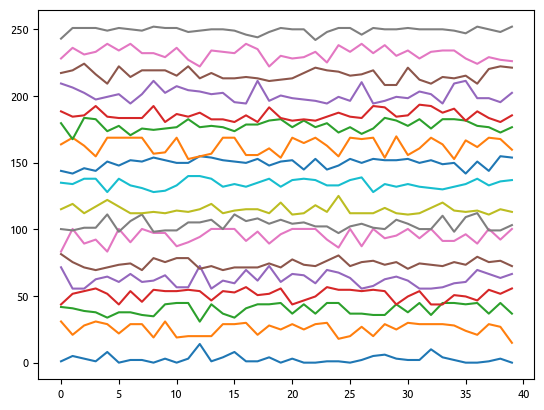

In [472]:
plt.plot(ranks.T + np.arange(0, 250, 250/18))
pass

In [10]:
view.subject_id.unique().shape

(40,)

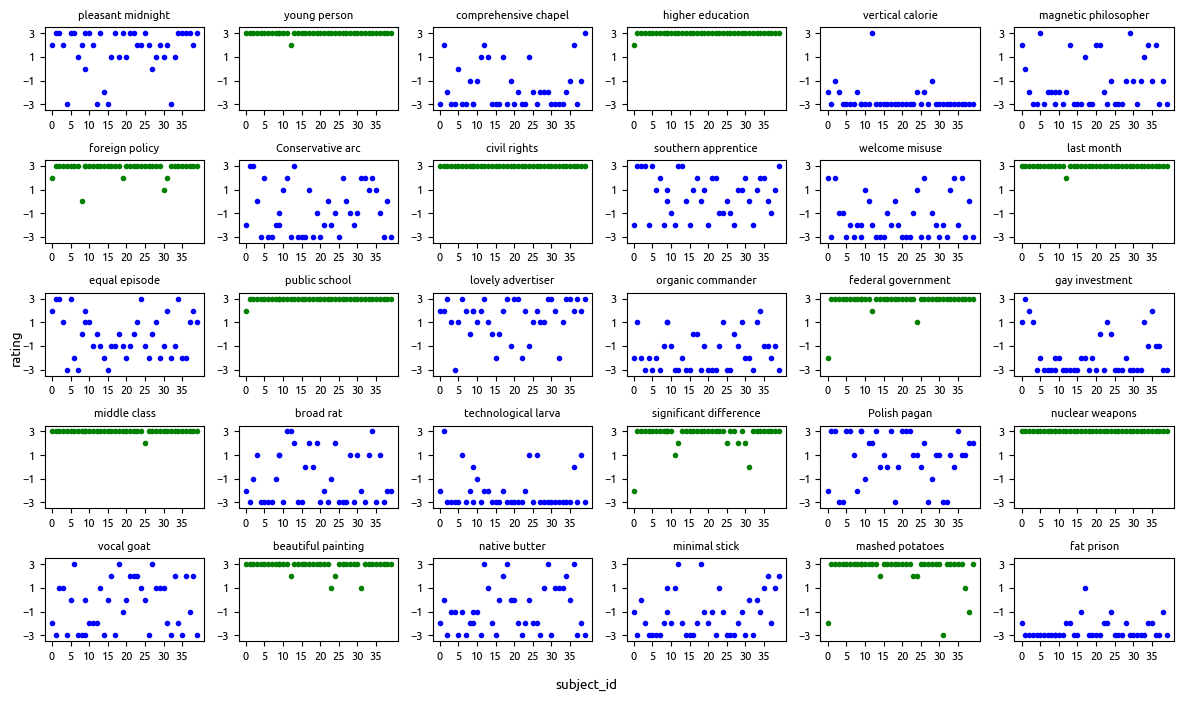

In [131]:
f, a = plt.subplots(5, 6, figsize=(12, 7))

view = df[df.trial_type != "crit"]
for i, item_id in enumerate(view.item_index.unique()):
    r, c = i // 6, i % 6
    a[r, c].plot(
        list(
            map(lambda x: subject_to_ix[x], view[view.item_index == item_id].subject_id)
        ),
        view[view.item_index == item_id].response,
        "g." if view[view.item_index == item_id].trial_type.iloc[0] == "gold" else "b.",
    )
    a[r, c].set(
        title=f"{view[view.item_index == item_id].item.iloc[0]}",
        ylim=(-3.5, 3.5),
        # xlabel="subject",
        # ylabel="rating",
        yticks=np.arange(-3, 3.1, 2),
        xticks=np.arange(0, len(view.subject_id.unique()), 5),
    )

f.supxlabel("subject_id")
f.supylabel("rating")


font = {
    "family": "Ubuntu",
    # 'weight' : 'bold',
    "size": 8,
}

matplotlib.rc("font", **font)

# plt.rcParams.update({"axes.titlesize": 8})
plt.tight_layout()
plt.show()


In [559]:
def split_groups_corr(
    df_obj: pd.DataFrame,
    random_state: int = None,
    randomize: bool = True,
    group1: slice = slice(0, None, 2),
    group2: slice = slice(1, None, 2),
    all_subj=None,
) -> scipy.stats._stats_py.PearsonRResult:

    all_subj = list(df_obj.subject_id.unique())

    if randomize:
        if random_state:
            random.seed(random_state)
        random.shuffle(all_subj)

    first_group = set(all_subj[group1])
    second_group = set(all_subj[group2])

    first_group_view = df_obj[df_obj.subject_id.isin(first_group)]
    second_group_view = df_obj[df_obj.subject_id.isin(second_group)]

    # return scipy.stats.pearsonr
    return (
        first_group_view.groupby("item_index").mean()["response"].to_numpy(),
        second_group_view.groupby("item_index").mean()["response"].to_numpy(),
    )


from functools import partial

split_halves_corr = partial(
    split_groups_corr,
    randomize=True,
    group1=slice(0, None, 2),
    group2=slice(1, None, 2),
)


def leave_one_out_corr(
    df_obj: pd.DataFrame,
    subject_id: str,
    numpy: bool = True,
) -> scipy.stats._stats_py.PearsonRResult:

    first_group_view = df_obj.loc[df_obj.subject_id != subject_id]
    second_group_view = df_obj.loc[df_obj.subject_id == subject_id]

    if numpy:
        return (
            first_group_view.groupby("item_index").mean()["response"].to_numpy(),
            second_group_view.groupby("item_index").mean()["response"].to_numpy(),
        )
    else:
        return (
            first_group_view.groupby("item_index").mean(),
            second_group_view.groupby("item_index").mean(),
        )


r=0.932, p=0.000, err=0.070


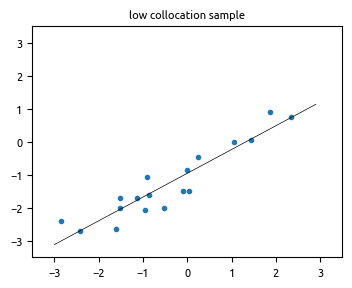

In [493]:
f, a = plt.subplots(figsize=(4,3))

x, y = split_halves_corr(df[df.trial_type.isin(["anti"])], random_state=None)
slope, intercept, r, p, err = scipy.stats.linregress(x, y)

a.plot( x, y, "." )
a.plot((xs := np.arange(-3, 3, .1)), intercept + slope * xs, 'k-', linewidth=.5)
a.set(xlim=(-3.5,3.5), ylim=(-3.5,3.5), title='low collocation sample')

print(f'r={r:.3f}, p={p:.3f}, err={err:.3f}')

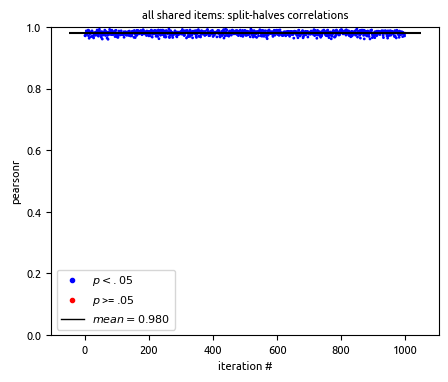

In [540]:
trial_types = ("anti", "gold")
N = 1_000
stats, pvals = [], []
for i in range(N):
    # pr = split_halves_corr(df[df.trial_type.isin([trial_type])], random_state=i)
    # stat, pval = pr.statistic, pr.pvalue
    x, y = split_halves_corr(df[df.trial_type.isin(trial_types)], random_state=i)
    slope, intercept, r, p, err = scipy.stats.linregress(x, y)

    stats += [r]
    pvals += [p]

stats, pvals = np.array(stats), np.array(pvals)
c_ix = (pvals < 0.05).astype("int")
# c_ix = np.where(c_ix, '$p<.05$', '$p\\geq.05$')
cmap = matplotlib.colors.ListedColormap(("r", "b"))
c_ix = np.where(c_ix, "b", "r")

f, a = plt.subplots(figsize=(5, 4))
scatter = a.scatter(
    np.arange(N),
    stats,
    s=1,
    c=c_ix,  # cmap=cmap, # label=np.where(c_ix == 1, '$p<.05$', '$p>=.05$')
)
hlines = a.hlines(
    [np.mean(stats)], xmin=-N / 20, xmax=N + N / 20, colors=["k"], label="mean={}"
)

a.set(
    ylabel="pearsonr",
    xlabel="iteration #",
    ylim=(0, 1),
    title="all shared items: split-halves correlations",
)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker=".", label="$p<.05$", lw=0, color="b"),
    Line2D([0], [0], marker=".", label="$p$ >= $.05$", lw=0, color="r"),
    Line2D([0], [0], marker="", label=f"$mean={np.mean(stats):.3f}$", lw=1, color="k"),
]
a.legend(handles=legend_elements)

plt.show()


In [494]:
x, y = leave_one_out_corr(df[df.trial_type.isin(["anti"])], '60b8db5feb283b86cce8de9f')
x, y

(array([ 1.55 , -1.575, -2.625, -1.2  , -0.675,  0.575, -1.425, -0.125,
         1.375, -1.5  , -1.825, -0.975, -2.125,  0.75 , -0.475, -0.75 ,
        -1.275, -2.575]),
 array([ 2., -3., -3., -3., -2., -1., -1.,  1.,  2., -1.,  1., -1., -2.,
         1.,  2., -2.,  1., -2.]))

r=0.799, p=0.000, err=0.103


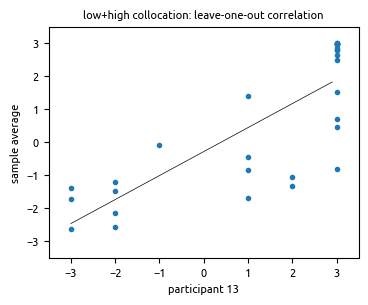

In [537]:
f, a = plt.subplots(figsize=(4, 3))

subj_id = df.subject_id.unique()[13]
y, x = leave_one_out_corr(df[df.trial_type.isin(["anti", "gold"])], subj_id)
slope, intercept, r, p, err = scipy.stats.linregress(x, y)

a.plot(x, y, ".")
a.plot((xs := np.arange(-3, 3, 0.1)), intercept + slope * xs, "k-", linewidth=0.5)
a.set(
    xlim=(-3.5, 3.5),
    ylim=(-3.5, 3.5),
    title="low+high collocation: leave-one-out correlation",
    ylabel="sample average",
    xlabel=f"participant {subject_to_ix[subj_id]}",
)

print(f"r={r:.3f}, p={p:.3f}, err={err:.3f}")


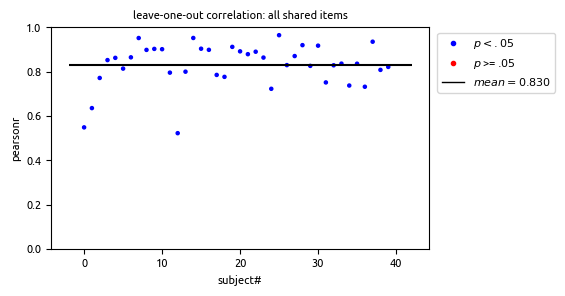

In [536]:
trial_types = ("anti", "gold")
N = len(df.subject_id.unique())
stats, pvals = [], []
for i, subj_id in enumerate(df.subject_id.unique()):
    # pr = split_halves_corr(df[df.trial_type.isin([trial_type])], random_state=i)
    # stat, pval = pr.statistic, pr.pvalue
    x, y = leave_one_out_corr(df[df.trial_type.isin(trial_types)], subj_id)
    slope, intercept, r, p, err = scipy.stats.linregress(x, y)

    stats += [r]
    pvals += [p]

stats, pvals = np.array(stats), np.array(pvals)
c_ix = (pvals < 0.05).astype("int")
# c_ix = np.where(c_ix, '$p<.05$', '$p\\geq.05$')
cmap = matplotlib.colors.ListedColormap(("r", "b"))
c_ix = np.where(c_ix, "b", "r")

f, a = plt.subplots(figsize=(6, 3))
scatter = a.scatter(
    np.arange(N),
    stats,
    s=5,
    c=c_ix,  # cmap=cmap, # label=np.where(c_ix == 1, '$p<.05$', '$p>=.05$')
)
hlines = a.hlines(
    [np.mean(stats)], xmin=-N / 20, xmax=N + N / 20, colors=["k"], label="mean={}"
)

a.set(
    ylabel="pearsonr",
    xlabel="subject#",
    ylim=(0, 1),
    title="leave-one-out correlation: all shared items",
)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker=".", label="$p<.05$", lw=0, color="b"),
    Line2D([0], [0], marker=".", label="$p$ >= $.05$", lw=0, color="r"),
    Line2D([0], [0], marker="", label=f"$mean={np.mean(stats):.3f}$", lw=1, color="k"),
]
a.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.35, 1.0))

plt.tight_layout()
plt.show()


In [574]:
leave_one_out_corr(view, subj_id, numpy=False)[0]

,age,rt,time_elapsed,trial_index,response
item_index,,,,,
12,31.125,4437.600,270837.000,12.0,1.550
18,31.125,3558.500,302770.450,18.0,2.975
25,31.125,5755.725,343303.200,25.0,-1.575
36,31.125,3682.775,414347.900,36.0,3.000
38,31.125,3862.750,422937.225,38.0,-2.650
50,31.125,4317.700,490679.875,50.0,-1.325
55,31.125,3488.925,517056.800,55.0,2.825
63,31.125,4661.325,553905.800,63.0,-0.675
73,31.125,2573.400,610436.600,73.0,3.000


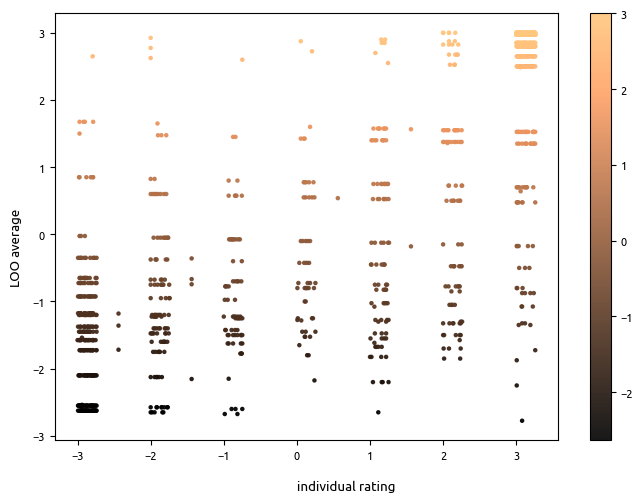

In [650]:
trial_types = ("anti", "gold")
N = len(df.subject_id.unique())
K = len(df[df.trial_type.isin(trial_types)]["item"].unique())

f, a = plt.subplots(
    # N,
    # K,
    figsize=(7, 5),
)

view = df[df.trial_type.isin(trial_types)]
avg_ratings = view.groupby("item_index").mean()["response"].to_dict()

for n, subj_id in enumerate(view.subject_id.unique()):
    y, x = leave_one_out_corr(view, subj_id, numpy=False)
    c = map(lambda ix: avg_ratings[ix], y.index)
    c = [*c]
    cmap = matplotlib.colormaps.get("copper")
    sc = a.scatter(
        x.response.to_numpy()+n/K/5, y.response.to_numpy(), c=c, s=5, cmap=cmap, alpha=0.9
    )
    # if n >= 2: break

plt.colorbar(sc)

f.supxlabel("individual rating")
f.supylabel("LOO average")

font = {"family": "Ubuntu", "size": 8}
matplotlib.rc("font", **font)

# plt.rcParams.update({"axes.titlesize": 8})
plt.tight_layout()
plt.show()
